# Metin's Ultimate Guide to get rich by forecasting stock returns using a Crystal Ball ...uhm...I mean ARIMA model

In [1]:
# Import libraries and dependencies
import numpy as np
from numpy import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
abs_path = Path(r'C:/Users/metin/Documents/nufintech/.env')
load_dotenv(abs_path) 


# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [14]:
# Set the ticker
ticker = "SPY"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2005-05-04", tz="America/New_York").isoformat()
from datetime import date
today = date.today()
end_date = pd.Timestamp(today.strftime("%Y-%m-%d"), tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
    ).df



In [15]:
df.tail()

SPY                                     
                             open    high       low   close     volume
time                                                                  
2020-06-23 00:00:00-04:00  313.49  314.49  311.6101  312.03   56029323
2020-06-24 00:00:00-04:00  309.84  310.51  302.1000  304.12  109892325
2020-06-25 00:00:00-04:00  303.47  307.64  301.2800  307.31   74516605
2020-06-26 00:00:00-04:00  306.16  306.39  299.4200  300.01  100618111
2020-06-29 00:00:00-04:00  301.41  304.45  298.9300  304.43   64142958

In [16]:
df.tail()

SPY                                     
                             open    high       low   close     volume
time                                                                  
2020-06-23 00:00:00-04:00  313.49  314.49  311.6101  312.03   56029323
2020-06-24 00:00:00-04:00  309.84  310.51  302.1000  304.12  109892325
2020-06-25 00:00:00-04:00  303.47  307.64  301.2800  307.31   74516605
2020-06-26 00:00:00-04:00  306.16  306.39  299.4200  300.01  100618111
2020-06-29 00:00:00-04:00  301.41  304.45  298.9300  304.43   64142958

In [17]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.tail()

,close
2020-06-23,312.03
2020-06-24,304.12
2020-06-25,307.31
2020-06-26,300.01
2020-06-29,304.43


In [18]:
# Use the `pct_change` function to calculate daily returns of AAPL
daily_returns = df.pct_change()
daily_returns.dropna(inplace=True)
daily_returns.head()

,close
2008-01-03,-0.000623
2008-01-04,-0.024436
2008-01-07,0.003761
2008-01-08,-0.018733
2008-01-09,0.014192


In [19]:
daily_returns.tail()

,close
2020-06-23,0.004345
2020-06-24,-0.025350
2020-06-25,0.010489
2020-06-26,-0.023755
2020-06-29,0.014733


### Up until now, we coppped out and pulled of some "bush league forecasting" by using the average daily return to forecast

In [20]:
# Use the `mean` function to calculate the mean of daily returns for AAPL
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.00032441150597946653

# Now we are ready to forecast Major League Style with ARIMAs

In [21]:
def metin_s_dickey_fuller(series):
    from statsmodels.tsa.stattools import adfuller
    series.dropna(inplace=True)
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value:        %f ' % result[1])
    print('Lags used:      %d' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))
    if result[1]<0.05:
        print(f'\nWohoo! The p-value is below the significance level of 0.05. \n\nWe can reject the hypothesis that the time series is non-stationary. GO PACK GO!!!')
    else: 
        print('\nwah waaah..p-value is above the significance level of 0.05. \n\nWe cannot reject the hypothesis that the time series is non-stationary. Better luck next time buddy!!')
    
#http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/

In [22]:
metin_s_dickey_fuller(daily_returns['close'])

ADF Statistic: -13.880041
p-value:        0.000000 
Lags used:      17
Critical Values:
1%: -3.432
5%: -2.862
10%: -2.567

Wohoo! The p-value is below the significance level of 0.05. 

We can reject the hypothesis that the time series is non-stationary. GO PACK GO!!!


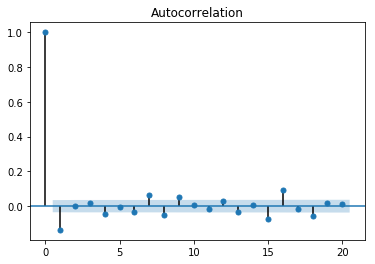

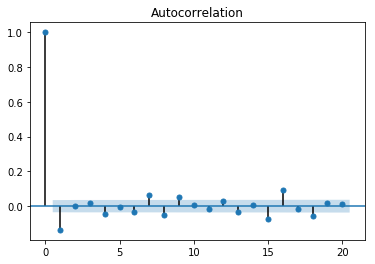

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(daily_returns['close'], lags=20)

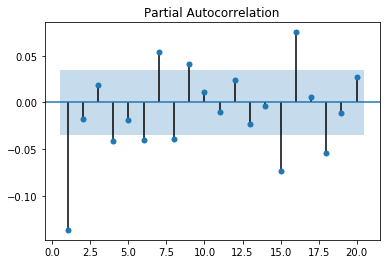

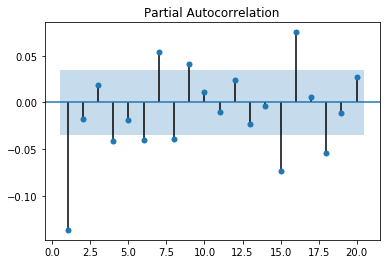

In [24]:
plot_pacf(daily_returns['close'], zero=False, lags=20)

In [25]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(daily_returns['close'], order=(1, 0, 1))

C:\Users\metin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [26]:
results = model.fit()

In [27]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 3144
Model:                     ARMA(1, 1)   Log Likelihood                9172.580
Method:                       css-mle   S.D. of innovations              0.013
Date:                Mon, 29 Jun 2020   AIC                         -18337.160
Time:                        19:37:00   BIC                         -18312.947
Sample:                             0   HQIC                        -18328.472
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0003      0.000      1.605      0.108   -7.16e-05       0.001
ar.L1.close    -0.0290      0.125     -0.232      0.817      -0.274       0.216
ma.L1.close    -0.1098      0.124     -0.882      0.378      -0.354       0.134
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -34.4919           +0.0000j           34.4919            0.5000
MA.1            9.1099           +0.0000j            9.1099            0.0000
-----------------------------------------------------------------------------
"""

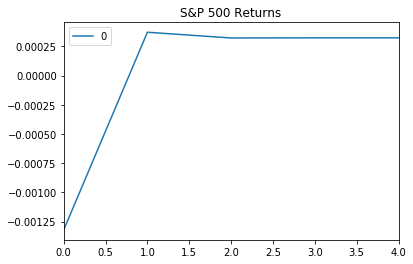

In [28]:
# Visualize the forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="S&P 500 Returns")

In [30]:
print(results.forecast(steps=1)[0])

[-0.00132097]


If you are up for the challenge, submit your forecast for the S&P 500 return (close to close) to our forecasting competition, starting Mon Jul 29th 2020 until Friday Jul 3rd 2020. Forecasts have to be submitted for the next day by midnight the day before.